<a href="https://colab.research.google.com/github/BenxiaHu/Python/blob/master/TAD_HiC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Directionality Index (DI) Approach
Conceptually introduced in the original Hi-C paper by Lieberman-Aiden et al. (Science, 2009), the Directionality Index (DI) captures whether a given bin
i tends to interact more with regions on the “left” side (upstream) or the “right” side (downstream) along the genome.

# 1. Define a window size L (in number of bins).
# 2. For each bin i, let
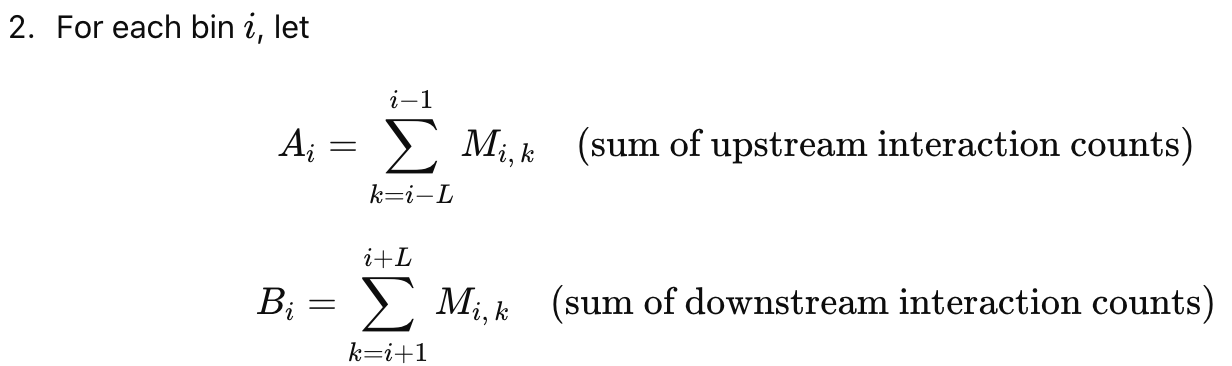

# 3. The directionality index for bin 𝑖 is often computed as:
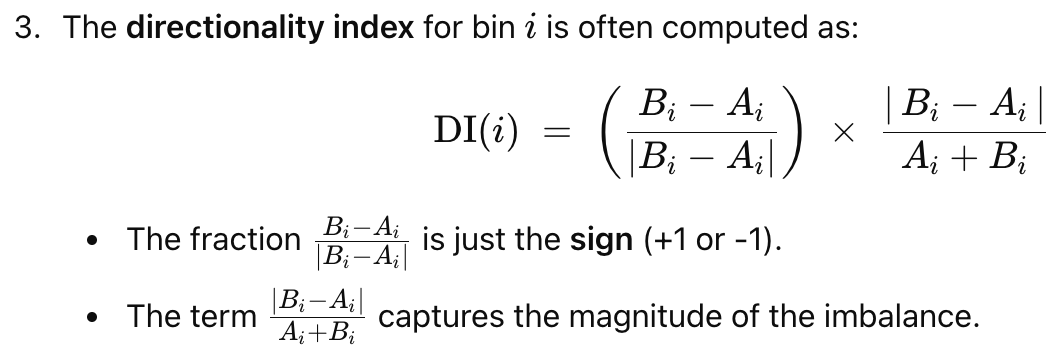

# 4. Identify domain boundaries where the DI transitions from positive to negative or from negative to positive. These transition points often indicate abrupt changes in the direction of contact enrichment.



# 2) Insulation Score Approach
Another widely used approach defines an insulation score for each bin 𝑖 by measuring how many interactions cross bin 𝑖 (within a certain window). In other words:
Choose a window size 𝐿 (in bin units).
For each bin 𝑖, sum the interactions in the submatrix that includes the bins from 𝑖−𝐿 to 𝑖 + 𝐿.
The insulation score is often defined so that a lower insulation score indicates stronger local “insulation,” which typically corresponds to a TAD boundary. (Different publications have slightly different formulas, but the idea is to measure how many interactions “span” across bin
𝑖.)
A TAD boundary is then identified by local maxima in the insulation score (or by local minima, depending on the specific sign convention).

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. Simulate a Hi-C Contact Matrix (M)

In [3]:
N = 1000  # number of bins
np.random.seed(42)  # for reproducibility

# Generate a random matrix
M_raw = np.random.poisson(lam=50, size=(N, N)).astype(float)
# Make it symmetric to mimic real Hi-C contact matrices
M_raw = 0.5 * (M_raw + M_raw.T)

# 2. Compute the Observed/Expected (O/E) Matrix

In [4]:
diag_sums = np.zeros(N)
diag_counts = np.zeros(N)
for i in range(N):
    for j in range(N):
        d = abs(i - j)
        diag_sums[d] += M_raw[i, j]
        diag_counts[d] += 1

diag_avgs = diag_sums / diag_counts

hic_matrix = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        d = abs(i - j)
        expected = diag_avgs[d]
        if expected == 0:
            hic_matrix[i, j] = 0
        else:
            hic_matrix[i, j] = M_raw[i, j] / expected

# 3. PARAMETERS


In [5]:
n_bins = len(hic_matrix)  # Should be 1000
window_size = 10           # L
directionality_indices = [0.0] * n_bins

# 4. COMPUTE DIRECTIONALITY INDEX (DI)

In [6]:
def directionality_index(hic_matrix, window_size=2):
    """
    Computes Directionality Index for each bin in a Hi-C matrix.
    Returns:
      - di_values: list of floats, the DI per bin
      - boundaries: list of bin indices where sign change occurs in DI
    """
    n_bins = len(hic_matrix)
    di_values = [0.0] * n_bins

    for i in range(n_bins):
        # Sum upstream (A_i)
        A = 0
        for k in range(max(0, i - window_size), i):
            A += hic_matrix[i][k]

        # Sum downstream (B_i)
        B = 0
        for k in range(i+1, min(n_bins, i + window_size + 1)):
            B += hic_matrix[i][k]

        # Compute DI(i)
        if (A + B) == 0 or (B == A):
            di_values[i] = 0.0
        else:
            sign_part = (B - A) / abs(B - A)  # +1 or -1
            mag_part = abs(B - A) / (A + B)   # magnitude of imbalance
            di_values[i] = sign_part * mag_part

    # Identify boundaries by sign changes in DI
    boundaries = []
    for i in range(1, n_bins):
        if di_values[i - 1] * di_values[i] < 0:  # sign change
            boundaries.append(i)

    return di_values, boundaries

# 5. INSULATION SCORE APPROACH

In [7]:
def insulation_score(hic_matrix, window_size=2):
    """
    Computes a simple insulation score for each bin:
    - For each bin i, sum the submatrix from (i-L to i+L) in both dimensions.
    - We define insulation score = negative sum (lower sum => stronger insulation).
    Returns:
      - ins_values: list of floats, insulation scores
      - boundaries: list of bin indices (local minima of ins_values)
    """
    n_bins = len(hic_matrix)
    ins_values = [0.0] * n_bins

    for i in range(n_bins):
        region_sum = 0
        left = max(0, i - window_size)
        right = min(n_bins - 1, i + window_size)
        # sum submatrix
        for r in range(left, right + 1):
            for c in range(left, right + 1):
                region_sum += hic_matrix[r][c]
        # negative region sum as a proxy for insulation
        ins_values[i] = -region_sum

    # Local minima detection in ins_values
    boundaries = []
    for i in range(1, n_bins - 1):
        if ins_values[i] < ins_values[i - 1] and ins_values[i] < ins_values[i + 1]:
            boundaries.append(i)

    return ins_values, boundaries

# 6. CALCULATE DI & INSULATION + IDENTIFY BOUNDARIES

In [10]:
di_vals, di_bndry = directionality_index(hic_matrix, window_size=2)
ins_vals, ins_bndry = insulation_score(hic_matrix, window_size=2)

print("=== Directionality Index (DI) ===")
for i, val in enumerate(di_vals):
    print(f"Bin {i}: DI = {val:.3f}")
print("DI Boundaries (sign changes):", di_bndry)

print("\n=== Insulation Score (negative region sum) ===")
for i, val in enumerate(ins_vals):
    print(f"Bin {i}: Insulation = {val:.3f}")
print("Insulation Boundaries (local minima):", ins_bndry)

=== Directionality Index (DI) ===
Bin 0: DI = 1.000
Bin 1: DI = 0.294
Bin 2: DI = 0.089
Bin 3: DI = -0.007
Bin 4: DI = 0.025
Bin 5: DI = 0.020
Bin 6: DI = -0.045
Bin 7: DI = 0.033
Bin 8: DI = -0.069
Bin 9: DI = 0.023
Bin 10: DI = 0.015
Bin 11: DI = -0.005
Bin 12: DI = -0.048
Bin 13: DI = -0.054
Bin 14: DI = 0.156
Bin 15: DI = -0.000
Bin 16: DI = -0.042
Bin 17: DI = 0.017
Bin 18: DI = -0.030
Bin 19: DI = -0.031
Bin 20: DI = 0.065
Bin 21: DI = -0.052
Bin 22: DI = -0.000
Bin 23: DI = 0.060
Bin 24: DI = -0.094
Bin 25: DI = 0.048
Bin 26: DI = -0.015
Bin 27: DI = 0.054
Bin 28: DI = -0.035
Bin 29: DI = -0.022
Bin 30: DI = 0.023
Bin 31: DI = 0.047
Bin 32: DI = 0.076
Bin 33: DI = -0.065
Bin 34: DI = -0.117
Bin 35: DI = 0.013
Bin 36: DI = 0.074
Bin 37: DI = 0.033
Bin 38: DI = -0.012
Bin 39: DI = -0.049
Bin 40: DI = 0.017
Bin 41: DI = -0.010
Bin 42: DI = 0.003
Bin 43: DI = -0.015
Bin 44: DI = 0.042
Bin 45: DI = -0.035
Bin 46: DI = 0.003
Bin 47: DI = -0.013
Bin 48: DI = 0.020
Bin 49: DI = 0.005
Bi

# 7. PLOT RESULTS

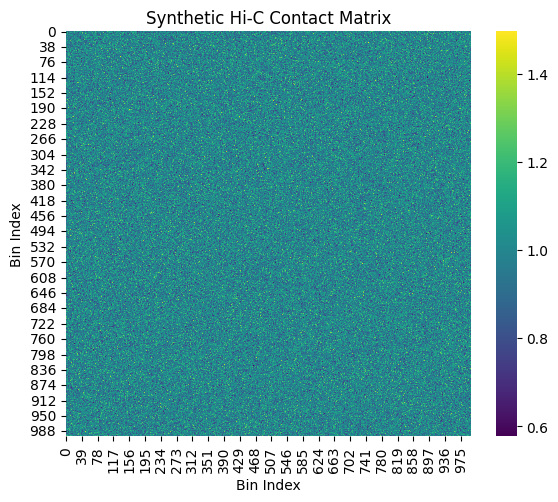

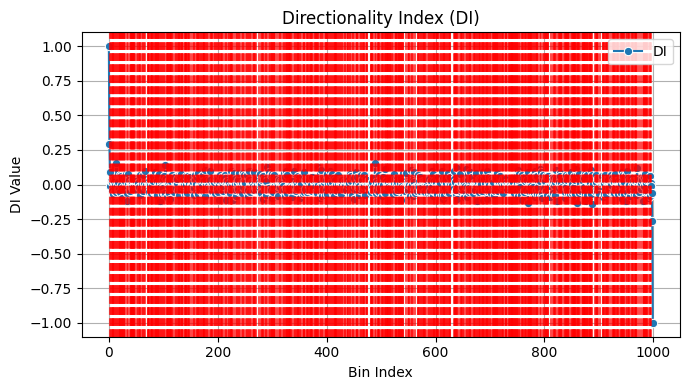

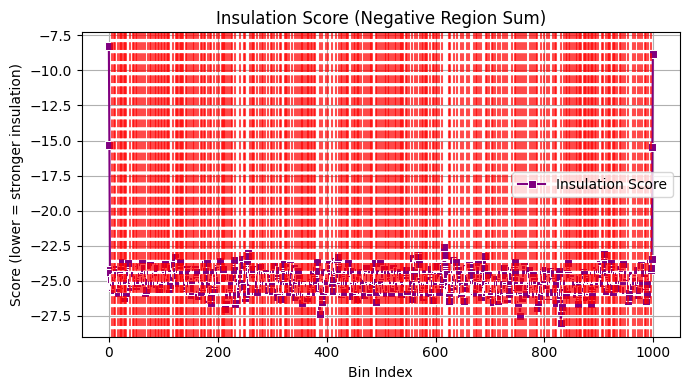

In [11]:
# 5a. Heatmap of the Hi-C Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(hic_matrix, annot=False, cmap='viridis', square=True)
plt.title("Synthetic Hi-C Contact Matrix")
plt.xlabel("Bin Index")
plt.ylabel("Bin Index")
plt.tight_layout()
plt.show()

# 5b. Directionality Index Plot
plt.figure(figsize=(7, 4))
sns.lineplot(x=range(len(di_vals)), y=di_vals, marker='o', label='DI')
for b in di_bndry:
    plt.axvline(x=b, color='red', linestyle='--', alpha=0.7)
plt.title("Directionality Index (DI)")
plt.xlabel("Bin Index")
plt.ylabel("DI Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 5c. Insulation Score Plot
plt.figure(figsize=(7, 4))
sns.lineplot(x=range(len(ins_vals)), y=ins_vals, marker='s', color='purple', label='Insulation Score')
for b in ins_bndry:
    plt.axvline(x=b, color='red', linestyle='--', alpha=0.7)
plt.title("Insulation Score (Negative Region Sum)")
plt.xlabel("Bin Index")
plt.ylabel("Score (lower = stronger insulation)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()